# Лабораторная работа 4. Поиск похожих изображений

### Работу выполнил:<span style="color:blue"> {Фамилия Имя}</span>

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/Ehvxe8lUDRBHs65SN0DjkekBFaiDh5VTile1HKnYSUwlNg)

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### 1. SIFT

In [7]:
img = cv2.imread('lena.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
img = cv2.drawKeypoints(gray,kp, img)

<img src="sift_keypoints.jpg" alt="drawing" width="300"/>

Про матчеры можно познакомиться подробнее в <a href="https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html">статье</a>.

724
[149.7698211669922, 151.03311157226562, 151.482666015625, 161.52398681640625, 162.9539794921875, 165.39952087402344, 173.7152862548828, 174.0804443359375, 176.5870819091797, 177.78919982910156]


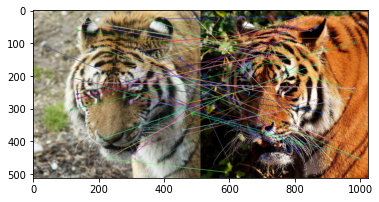

In [14]:
A = cv2.imread("images/0.jpg")
grayA= cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
B = cv2.imread("images/22.jpg")
grayB= cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kpA, desA = sift.detectAndCompute(grayA, None)
sift = cv2.SIFT_create()
kpB, desB = sift.detectAndCompute(grayB, None)

# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# match descriptors of both images
matches = bf.match(desA, desB)

# sort matches by distance
matches = sorted(matches, key=lambda x:x.distance)
# draw first 50 matches
matched_img = cv2.drawMatches(A, kpA, B, kpB, matches[:50], None, flags=2)
plt.imshow(matched_img[:, :, ::-1])
print(len(matches))
print([x.distance for x in matches[:10]])

### 5. Задание

Напишите скрипт/программу/систему поиска в коллекции изображений (dataset) похожих на запросную картинку (задается пользователем).
<br>
Размеры всех изображений составляют 512х512 пикселей.
<br>
<div>
Реализуйте несколько способов поиска на основе:
<ol>
    <li>гистограммы цветов;</li>
    <li>гистограммы градиентов;</li>
    <li>SIFT</li>
</ol>
</div>
Для каждого способа продумайте способы оценивания сходства векторов изображений. Например, для SIFT можно использовать количество совпавших особых точек или, например, среднее расстояние между первыми десятью совпавшими парами.
<div>
    Данные - Content Based Image Retrieval (CBIR) <a href="https://www.kaggle.com/datasets/theaayushbajaj/cbir-dataset">dataset</a> 
</div>

Сделайте графический интерфейс, например, посредством библиотеки gradio (см. <a href="https://www.gradio.app/guides/quickstart">краткое руководство</a>, <a href="https://huggingface.co/docs/hub/spaces-sdks-gradio">пример</a> и ещё  <a href="https://dev.to/haoliyin/show-off-your-computer-vision-model-with-gradio-1k3o">пример</a>)

Примерный графический интерфейс
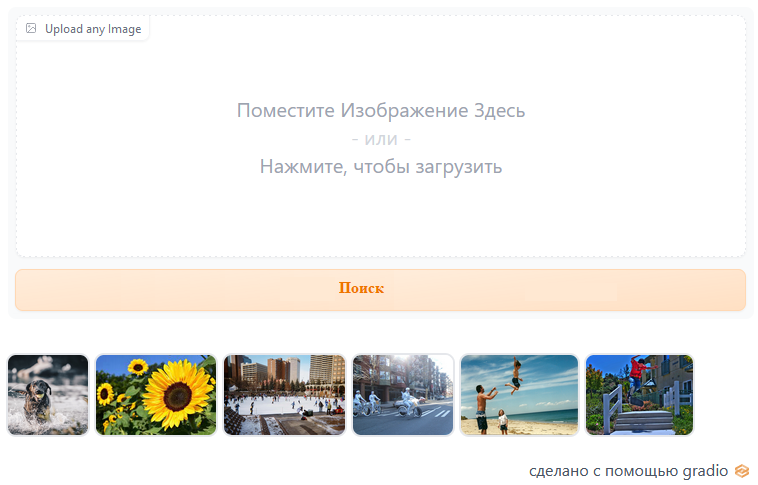

**(!) При разработке и тестировании кода работайте с 10-20 картинками из датасета, а потом уже запускайте работу со всей коллекцией изображений**

Примерные этапы, которые нужно реализовать:
1. Создание массива векторов признаков, описывающих содержание изображений (возможно стоит включить некоторую предобработку каждого изображения)
2. Предобработка и загрузка запросного изображения, для которой будет выполняться поиск похожих изображений
3. Вычисление вектора, описывающего содержание загруженного изображения
4. Сравнение вектора загруженого изображения с векторами из массива
5. Выбрать три наиболее подходящих изображения из коллекции по некоторой метрике сходства

**Сделайте выводы о наилучшем и наихудшем разработанном способе поиска похожих изображений.**

In [13]:
#Ваш код